# Wiener SBND Unfolding for numu CC 1p0pi 

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm

# local imports
from variable_configs import *

sys.path.append('/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana')
from analysis_village.unfolding.wienersvd import *
from analysis_village.unfolding.unfolding_inputs import *
from pyanalib.split_df_helpers import *
from makedf.mcstat import *

plt.style.use("presentation.mplstyle")

In [187]:
save_fig = False
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/wiener_svd/1mu1p"

In [188]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

# load dataframes

In [189]:
## -- MC study
mc_file = "/exp/sbnd/data/users/munjung/xsec/2025B/MC_test.df"
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

mc_n_split: 1
Keys: ['/evt_0', '/hdr_0', '/mcnu_0', '/mcnuwgtslim_0', '/split']


In [190]:
n_max_concat = 2

mc_keys2load = ['evt', 'hdr', 'mcnuwgtslim']
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)

mc_evt_df = mc_dfs['evt']
mc_hdr_df = mc_dfs['hdr']
mc_nu_df = mc_dfs['mcnuwgtslim']

# Make MCstat uncertainty universes

In [191]:
mc_evt_df, MCstat_univ_events = mcstat(mc_evt_df, mc_hdr_df, n_universes=100)

# POT

In [192]:
## total pot
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))

target_pot = 1e20
mc_pot_scale = target_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_pot_scale = 1.

mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

mc_tot_pot: 1.504e+18
mc_pot_scale: 6.651e+01


# Constants

['flux_sbnd_numu;1', 'flux_sbnd_nue;1', 'flux_sbnd_anumu;1', 'flux_sbnd_anue;1']


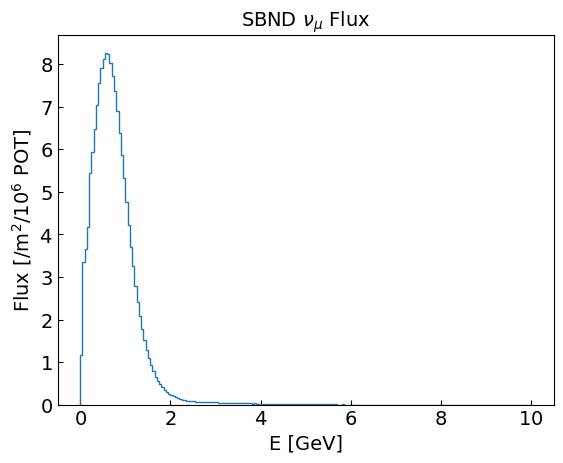

Integrated flux: 2.428e+10


In [193]:
# TODO: z-dependence?
# flux file, units: /m^2/10^6 POT 
# 50 MeV bins
fluxfile = "/exp/sbnd/data/users/munjung/flux/sbnd_original_flux.root"
flux = uproot.open(fluxfile)
print(flux.keys())

# numu flux
numu_flux = flux["flux_sbnd_numu"].to_numpy()
bin_edges = numu_flux[1]
flux_vals = numu_flux[0]

plt.hist(bin_edges[:-1], bins=bin_edges, weights=flux_vals, histtype="step")
plt.xlabel("E [GeV]")
plt.ylabel("Flux [/m$^{2}$/10$^{6}$ POT]")
plt.title("SBND $\\nu_\\mu$ Flux")
plt.show()

# get integrated flux
integrated_flux = flux_vals.sum()
integrated_flux /= 1e4 # to cm2
INTEGRATED_FLUX = integrated_flux * mc_tot_pot / 1e6 # POT
print("Integrated flux: %.3e" % INTEGRATED_FLUX)

In [194]:
RHO = 1.3836  #g/cm3, liquid Ar density
N_A = 6.02214076e23 # Avogadro’s number
M_AR = 39.95 # g, molar mass of argon
V_SBND = 380 * 380 * 440 # cm3, the active volume of the detector 
NTARGETS = RHO * V_SBND * N_A / M_AR
print("# of targets: ", NTARGETS)

# of targets:  1.3251484770937053e+30


In [195]:
# set to 1 for event rates
XSEC_UNIT = 1 / (INTEGRATED_FLUX * NTARGETS)

# XSEC_UNIT = 1
print("xsec unit: ", XSEC_UNIT)

xsec unit:  3.1078419006811257e-41


# Set up utils and selections according to target channel

In [196]:
def InFV(data): # cm
    xmin = -190.
    ymin = -190.
    zmin = 10.
    xmax = 190.
    ymax =  190.
    zmax =  450.
    return (np.abs(data.x) > 10) & (np.abs(data.x) < 190) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)


def IsNu(df):
    return ~df.pdg.isna()


def IsSignal(df): # definition                                                                                                                                                                                                                                                                         
    is_fv = InFV(df.position)
    is_1mu1p0pi = (df.nmu_27MeV == 1) & (df.npi_30MeV == 0) & (df.np_50MeV == 1) & (df.npi0 == 0) & (df.mu.genE < 1.2) # & (df.np_20MeV == 1) : add with stubs
    return is_fv & is_1mu1p0pi


def Is1muNp0pi(df): # definition                                                                                                                                                                                                                                                                         
    is_fv = InFV(df.position)
    is_1mu1p0pi = (df.nmu_27MeV == 1) & (df.npi_30MeV == 0) & (df.np_50MeV > 1) & (df.npi0 == 0) #& (df.mu.genE > 0.25) # & (df.np_20MeV == 1) : add with stubs
    return is_fv & is_1mu1p0pi


def Is1muNcpi(df): # definition                                                                                                                                                                                                                                                                         
    is_fv = InFV(df.position)
    is_1mu1p0pi = (df.nmu_27MeV == 1) & (df.npi_30MeV > 0) & (df.npi0 == 0) #& (df.mu.genE > 0.25) # & (df.np_20MeV == 1) : add with stubs
    return is_fv & is_1mu1p0pi

In [197]:
def get_int_category(df):
    is_notnu = ~IsNu(df)
    is_nu_outfv = IsNu(df) & ~InFV(df.position)
    is_signal = IsSignal(df)
    is_1muNp0pi = Is1muNp0pi(df)
    is_1muNcpi = Is1muNcpi(df)

    # assert there's no overlap between the categories, just in case i messed something up...
    assert (is_1muNp0pi & is_1muNcpi).sum() == 0
    assert (is_1muNp0pi & is_signal).sum() == 0
    assert (is_1muNcpi & is_signal).sum() == 0
    assert (is_1muNp0pi & is_nu_outfv).sum() == 0
    assert (is_1muNcpi & is_nu_outfv).sum() == 0
    assert (is_signal & is_nu_outfv).sum() == 0
    is_other_nu_infv = IsNu(df) & InFV(df.position) & ~IsSignal(df) & ~Is1muNp0pi(df) & ~Is1muNcpi(df)

    nuint_categ = pd.Series(8, index=df.index)
    nuint_categ[is_notnu] = -1  # not nu
    nuint_categ[is_nu_outfv] = 0  # nu out of FV
    nuint_categ[is_signal] = 1    # nu in FV, signal
    nuint_categ[is_1muNp0pi] = 2  # 1mu, 0cpi, Np, 0pi0
    nuint_categ[is_1muNcpi] = 3  # 1mu, Ncpi, 0pi0
    nuint_categ[is_other_nu_infv] = 4  # nu in FV, not signal

    return nuint_categ


# the signal mode code needs to be the first item in the list for all the code below to work
mode_list = [1, 2, 3, 4, 0, -1]
mode_labels = ["Signal", r"$1\mu N(>1)p 0\pi^{\pm}$", r"$1\mu Ncpi$", "Other FV Nu", "Non FV Nu", "Not Nu"]

colors = ["mediumslateblue",
              "darkslateblue",
              "darkgreen",
              "crimson",
              "sienna",
              '#7f7f7f']

In [198]:
# additional selection?
mc_evt_df = mc_evt_df[InFV(mc_evt_df.slc.vertex,)]

# neutrino cuts
mc_evt_df = mc_evt_df[mc_evt_df.slc.nu_score > 0.5]

# require both muon and proton to be present
mask = (~np.isnan(mc_evt_df.mu.pfp.trk.P.p_muon)) & (~np.isnan(mc_evt_df.p.pfp.trk.P.p_proton))
mc_evt_df = mc_evt_df[mask]

# muon length cut
mc_evt_df = mc_evt_df[mc_evt_df.mu.pfp.trk.len > 50]

# containment cut
mc_evt_df = mc_evt_df[mc_evt_df.mu.pfp.trk.is_contained == True]
mc_evt_df = mc_evt_df[mc_evt_df.p.pfp.trk.is_contained == True]

# mu chi2 cut 
mc_evt_df = mc_evt_df[(mc_evt_df.mu.pfp.trk.chi2pid.I2.chi2_muon > 0) & (mc_evt_df.mu.pfp.trk.chi2pid.I2.chi2_muon < 25) & (mc_evt_df.mu.pfp.trk.chi2pid.I2.chi2_proton > 100)]

# protons chi2 cut
mc_evt_df = mc_evt_df[(mc_evt_df.p.pfp.trk.chi2pid.I2.chi2_proton > 0) & (mc_evt_df.p.pfp.trk.chi2pid.I2.chi2_proton < 90)]

# 1p0pi
twoprong_cut = (np.isnan(mc_evt_df.other_shw_length) & np.isnan(mc_evt_df.other_trk_length))
mc_evt_df = mc_evt_df[twoprong_cut]


In [199]:
# Turn unisims into multisims with 2 universes
knobs = [
    'GENIEReWeight_SBN_v1_multisigma_RPA_CCQE',
    'GENIEReWeight_SBN_v1_multisigma_CoulombCCQE',
    'GENIEReWeight_SBN_v1_multisigma_NormCCMEC',
    # 'GENIEReWeight_SBN_v1_multisigma_NormNCMEC',
    # 'GENIEReWeight_SBN_v1_multisigma_RDecBR1gamma',
]

# knob = knobs[2]
for knob in knobs:
    mc_evt_df[(knob, "univ_0", "", "", "", "", "", "")] = mc_evt_df[knob].ps1
    mc_evt_df[(knob, "univ_1", "", "", "", "", "", "")] = mc_evt_df[knob].ms1

In [200]:
# classify events into categories
mc_evt_df.loc[:,'nuint_categ'] = get_int_category(mc_evt_df)
mc_nu_df.loc[:,'nuint_categ'] = get_int_category(mc_nu_df)

print(mc_evt_df.nuint_categ.value_counts())
print(mc_nu_df.nuint_categ.value_counts()) # won't have -1 because nudf is all nu events

nuint_categ
 1    534
 4     64
 2     20
 3     12
-1      5
Name: count, dtype: int64
nuint_categ
0    21855
4     4862
1     2796
2     1094
3     1038
Name: count, dtype: int64


In [201]:
# choose a variable to unfold, defined in variable_configs.py
var_config = VariableConfig.muon_momentum()

In [202]:
genie_mode_list = [0, 10, 1, 2, 3]
genie_mode_labels = [r'$\nu_{\mu}$ CC QE', r'$\nu_{\mu}$ CC MEC', r'$\nu_{\mu}$ CC RES', r'$\nu_{\mu}$ CC SIS/DIS', r'$\nu_{\mu}$ CC COH'] #, r'not $\nu$']
# [r"non FV $\nu$", "Cosmic", r"$\nu$ NC"] + 
genie_mode_colors = ["#9b5580", "#390C1E", "#2c7c94", "#D88A3B", "#BFB17C"] #, '#7f7f7f']
# ["sienna", "crimson", "darkgreen"] + 

# Make dfs for analysis

np.clip is for including underflow events into the first bin and overflow events into the last bin

In [203]:
# Total MC reco muon momentum: for fake data
eps = 1e-8
var_total_mc = mc_evt_df[var_config.var_evt_reco_col]
var_total_mc = np.clip(var_total_mc, var_config.bins[0], var_config.bins[-1] - eps)
weights_total_mc = mc_evt_df.loc[:, 'pot_weight']

# --- all events, selected ---
# mc_evt_df divided into topology modes for subtraction from data in future
# first item in list is the signal topology
mc_evt_df_divided = [mc_evt_df[mc_evt_df.nuint_categ == mode]for mode in mode_list]

# Reco variable distribution for each 'nuint_categ' for stack plot and subtraction from the fake data
var_per_nuint_categ_mc = [mc_evt_df[mc_evt_df.nuint_categ == mode][var_config.var_evt_reco_col]for mode in mode_list]
var_per_nuint_categ_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_nuint_categ_mc]
weights_per_categ = [mc_evt_df.loc[mc_evt_df.nuint_categ == mode, 'pot_weight'] for mode in mode_list]

# Reco variable distribution for each genie mode
var_per_genie_mode_mc = [mc_evt_df[mc_evt_df.genie_mode == mode][var_config.var_evt_reco_col]for mode in genie_mode_list]
var_per_genie_mode_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_genie_mode_mc]
weights_per_genie_mode = [mc_evt_df.loc[mc_evt_df.genie_mode == mode, 'pot_weight'] for mode in genie_mode_list]


# --- signal events ---
# selected, for response matrix
# Signal event's reco muon momentum after the event selection
var_signal_sel_reco = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_reco_col]
var_signal_sel_reco = np.clip(var_signal_sel_reco, var_config.bins[0], var_config.bins[-1] - eps)
weight_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# Signal event's true muon momentum after the event selection
var_signal_sel_truth = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_truth_col]
var_signal_sel_truth = np.clip(var_signal_sel_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_true_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# total generated, for efficiency vector
# Signal event's true muon momentum without event selection
var_truth_signal = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
var_truth_signal = np.clip(var_truth_signal, var_config.bins[0], var_config.bins[-1] - eps)
weight_truth_signal = np.full_like(var_truth_signal, mc_pot_scale, dtype=float)

# Response Matrix

Draw true (before event selection) and reco (after event selection) muon momentum distributions of signal events.
Print entries for double check.

[329. 468. 458. 410. 314. 273. 195. 148. 133.  68.]
[ 34. 150. 122.  77.  59.  30.  33.  19.   9.   1.]
[ 34. 151. 112.  79.  60.  35.  30.  18.  12.   3.]


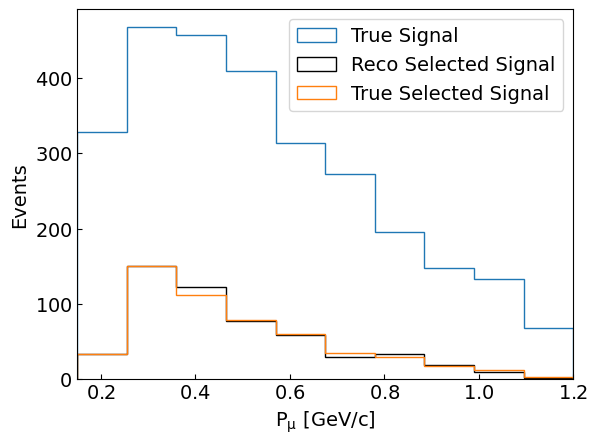

In [204]:
nevts_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_truth_signal, histtype="step", label="True Signal")
nevts_signal_sel_reco, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=weight_signal, histtype="step", label="Reco Selected Signal", color="k")
nevts_signal_sel_truth, _, _ = plt.hist(var_signal_sel_truth, bins=var_config.bins, weights=weight_signal, histtype="step", label="True Selected Signal")
print(nevts_signal_truth)
print(nevts_signal_sel_reco)
print(nevts_signal_sel_truth)
plt.legend()
plt.ylabel("Events")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
if save_fig:
    plt.savefig("{}/{}-sel_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

[[ 30.   4.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  4. 138.   9.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   7. 101.   4.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   9.  66.   3.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   6.  51.   2.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   4.  26.   5.   0.   0.   0.]
 [  0.   0.   0.   1.   1.   2.  25.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   3.  13.   2.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   5.   7.   0.]
 [  0.   0.   2.   0.   0.   0.   0.   0.   0.   1.]]


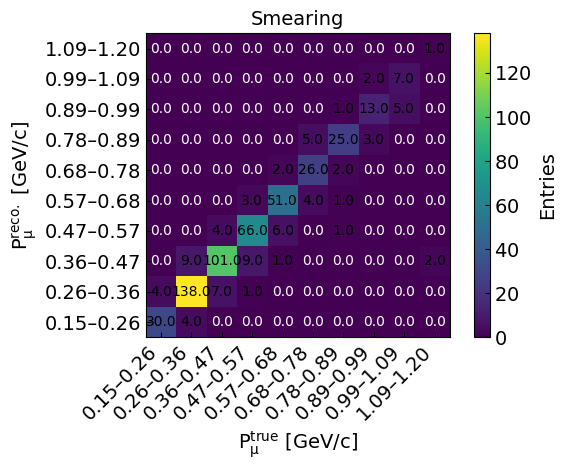

eff
[0.10334347 0.32264957 0.24454148 0.19268293 0.1910828  0.12820513
 0.15384615 0.12162162 0.09022556 0.04411765]


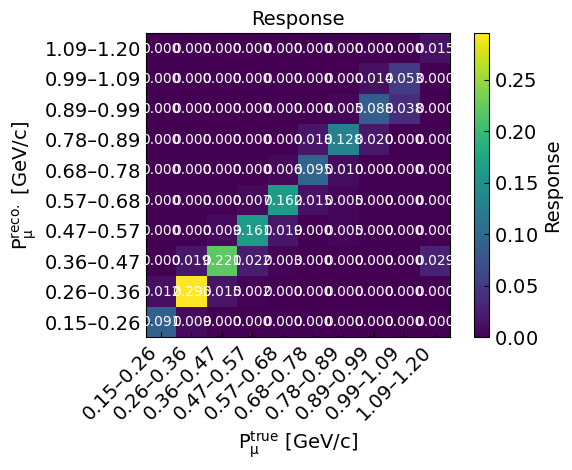

In [205]:
bins_2d = var_config.bins# = [np.array([0.2, 2]), np.array([0.2, 2])] # commented out lines for 1 bin MC closure test

save_fig_name = "{}/{}-reco_vs_true".format(save_fig_dir, var_config.var_save_name)
reco_vs_true = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, bins_2d, var_labels=var_config.var_labels,
                                save_fig=save_fig, save_fig_name=save_fig_name)
eff = get_eff(reco_vs_true, nevts_signal_truth)
print("eff")
print(eff)

save_fig_name = "{}/{}-response_matrix".format(save_fig_dir, var_config.var_save_name)
Response = get_response_matrix(reco_vs_true, eff, var_config.bins, var_labels=var_config.var_labels,
                               save_fig=save_fig, save_fig_name=save_fig_name)

# Covariance

In [206]:
def get_covariance(cov_type, syst_name, n_univ, 
                   nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, bins, 
                   var_labels, save_fig=False, save_fig_name=None):

    if cov_type == "xsec":
        scale_factor = XSEC_UNIT
        print("generating covariance for xsec, using scale factor: {}".format(scale_factor))

    elif cov_type == "event":
        print("generating covariance for event rate")
        scale_factor = 1

    else:
        raise ValueError("Invalid cov_type: {}".format(cov_type))

    
    signal_cv = nevts_signal_sel_reco * scale_factor # = Response @ true_signal

    Covariance_Frac = np.zeros((len(signal_cv), len(signal_cv)))
    Covariance = np.zeros((len(signal_cv), len(signal_cv)))

    univ_events = []
    for uidx in range(n_univ):
        univ_col_evt = (syst_name, "univ_{}".format(uidx), "", "", "", "", "", "")
        univ_col_mc = (syst_name, "univ_{}".format(uidx), "")

        # ---- uncertainty on the signal rate ----
        # GENIE syst need special treatment
        # we don't want uncertainty on the xsec
        # only consider its effect on the response matrix
        if syst_name == "GENIE" and cov_type == "xsec":
            true_signal_univ, _ = np.histogram(var_truth_signal, bins=var_config.bins, 
                                            weights=weight_truth_signal*mc_nu_df[mc_nu_df.nuint_categ == 1][univ_col_mc])
            
            # new response matrix for univ
            reco_vs_true = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                                            weights=mc_evt_df[mc_evt_df.nuint_categ == 1][univ_col_evt], plot=False)

            eff = get_eff(reco_vs_true, true_signal_univ) 

            Response_univ = get_response_matrix(reco_vs_true, eff, bins, plot=False)
            signal_univ = Response_univ @ nevts_signal_truth # note that we multiply the CV signal rate!

        # for other systs, we just take the univ signal event rate
        else:
            signal_univ, _ = np.histogram(var_signal_sel_reco, bins=var_config.bins, 
                                             weights=mc_evt_df[mc_evt_df.nuint_categ == 1][univ_col_evt])

        signal_univ = np.array(signal_univ) * scale_factor

        # ---- uncertainty on the background rate ----
        # loop over background categories
        # + univ background - cv background
        # note: cv background subtraction cancels out with the cv background subtraction for the cv event rate. 
        #       doing it anyways for the plot of universes on background subtracted event rate.
        for this_mc_evt_df in mc_evt_df_divided[1:]:
            weights = this_mc_evt_df[univ_col_evt].copy()
            weights[np.isnan(weights)] = 1 ## IMPORTANT: make nan weights to 1. to ignore them
            this_var = this_mc_evt_df[var_config.var_evt_reco_col]
            this_var = np.clip(this_var, var_config.bins[0], var_config.bins[-1] - eps)
            background_univ, _ = np.histogram(this_var, bins=var_config.bins, weights=weights)
            background_cv, _ = np.histogram(this_var, bins=var_config.bins)
            background_univ = np.array(background_univ) * scale_factor
            background_cv = np.array(background_cv) * scale_factor
            signal_univ += background_univ - background_cv

        univ_events.append(signal_univ)
        plt.hist(var_config.bin_centers, bins=var_config.bins, weights=signal_univ, histtype="step", color="gray")

        # ---- covariance calculation ----
        # I'm looping & calculating with the CV value for clarity, 
        # but techincally np.cov should also be fine under the assumption of gaussian universes that we're using
        for i in range(len(signal_univ)):
            for j in range(len(signal_univ)):
                nom_i = signal_cv[i] 
                nom_j = signal_cv[j] 

                univ_i = signal_univ[i] 
                univ_j = signal_univ[j] 

                cov_entry = (univ_i - nom_i) * (univ_j - nom_j)
                frac_cov_entry = ((univ_i - nom_i) / nom_i) * ( (univ_j - nom_j) / nom_j)

                # TODO: this clipping exists in the uboone code, but I'm not sure why..?
                # if cov_entry > 0:
                #     this_cov = max( cov_entry, eps * scale_factor)
                # else:
                #     this_cov = min( cov_entry, eps * scale_factor)

                # if frac_cov_entry > 0:
                #     this_frac_cov = max( frac_cov_entry, eps * scale_factor)
                # else:
                #     this_frac_cov = min( frac_cov_entry, eps * scale_factor)

                Covariance[i, j] += cov_entry
                Covariance_Frac[i, j] += frac_cov_entry

    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=signal_cv, histtype="step", color="black", label="nominal_event")

    plt.xlim(var_config.bins[0], var_config.bins[-1])
    plt.xlabel(var_config.var_labels[0])
    plt.ylabel(var_config.var_labels[1])
    plt.title(syst_name)
    plt.legend()
    plt.show()

    Covariance = Covariance / n_univ
    Covariance_Frac = Covariance_Frac / n_univ
    Correlation = np.zeros_like(Covariance)
    for i in range(len(signal_cv)):
        for j in range(len(signal_cv)):
            Correlation[i, j] = Covariance[i, j] / (np.sqrt(Covariance[i, i]) * np.sqrt(Covariance[j, j]))

    if save_fig:
        plt.savefig("{}.pdf".format(save_fig_name), bbox_inches='tight')
    plt.show()

    return {"Covariance_Frac": Covariance_Frac, 
            "Covariance": Covariance,
            "Correlation": Correlation,
            "cv_events": signal_cv,
            "univ_events": univ_events,
            }

In [207]:
# pretty heatmap plotter

unif_bin = np.linspace(0., float(len(var_config.bins) - 1), len(var_config.bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]

x_edges = np.array(var_config.bins)
y_edges = np.array(var_config.bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

def plot_heatmap(matrix, title, plot_labels=var_config.var_labels, save_fig=False, save_fig_name=None):
    plt.imshow(matrix, extent=extent, origin="lower")
    plt.colorbar()
    plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
    plt.yticks(y_tick_positions, y_labels)
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    for i in range(matrix.shape[0]):      # rows (y)
        for j in range(matrix.shape[1]):  # columns (x)
            value = matrix[i, j]
            if not np.isnan(value):  # skip NaNs
                plt.text(
                    j + 0.5, i + 0.5,
                    f"{value:.2f}",
                    ha="center", va="center",   
                    color=get_text_color(value),
                    fontsize=10
                )
    plt.title(title)
    if save_fig:
        plt.savefig("{}.pdf".format(save_fig_name), bbox_inches='tight')
    plt.show();

## MC Stat

The average of universes' weights is not within the tolerance of the CV value


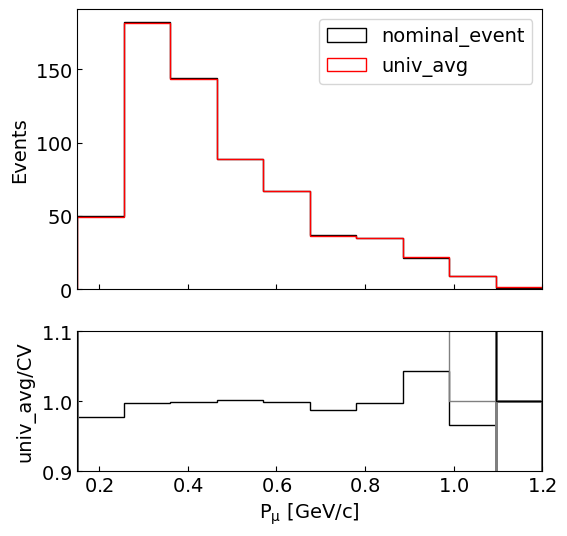

In [208]:
# check that the average of universes' weights is ~ CV value
univ_avg = mc_evt_df.MCstat.mean(axis=1)
fig, ax = plt.subplots(2,1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
cv_events, _, _ = ax[0].hist(mc_evt_df[var_config.var_evt_reco_col], bins=var_config.bins, histtype="step", color="black", label="nominal_event")
univ_avg_events, _, _ = ax[0].hist(mc_evt_df[var_config.var_evt_reco_col], bins=var_config.bins, weights=univ_avg, histtype="step", color="red", label="univ_avg")
ax[0].set_xlim(var_config.bins[0], var_config.bins[-1])
ax[0].set_ylabel("Events")
ax[0].legend()

bin_centers = (var_config.bins[1:] + var_config.bins[:-1]) / 2
ratio = univ_avg_events/cv_events
ax[1].hist(bin_centers, bins=var_config.bins, weights=ratio, histtype="step", color="black")
ax[1].set_xlim(var_config.bins[0], var_config.bins[-1])
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylabel("univ_avg/CV")
ax[1].set_xlabel(var_config.var_labels[0])
ax[1].set_ylim(0.9, 1.1)

tolerance = 0.05
if np.all(np.abs(ratio - 1) < tolerance):
    print("The average of universes' weights is within the tolerance of the CV value")
else:
    print("The average of universes' weights is not within the tolerance of the CV value")

for uidx in range(100):
    # print(uidx)
    plt.hist(mc_evt_df[var_config.var_evt_reco_col], bins=var_config.bins, weights=mc_evt_df["MCstat"][f"univ_{uidx}"], histtype="step", color="gray")

plt.hist(mc_evt_df[var_config.var_evt_reco_col], bins=var_config.bins, histtype="step", color="black", label="nominal_event")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.show()

generating covariance for xsec, using scale factor: 3.1078419006811257e-41


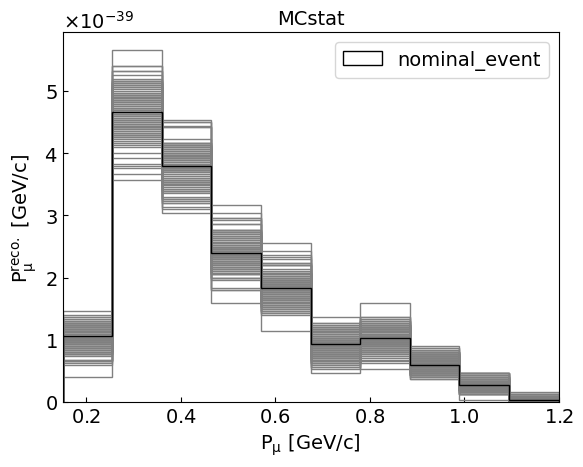

In [209]:
cov_type = "xsec"
syst_name = "MCstat"
n_univ = 100
labels = [var_config.var_labels[1], "Flux Integrated Event Rate"]

save_fig_name = "{}/{}-{}-mcstat_univ_events".format(save_fig_dir, var_config.var_save_name, syst_name)
ret_mcstat = get_covariance(cov_type, syst_name, n_univ, 
                            nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                            labels, save_fig=save_fig, save_fig_name=save_fig_name)

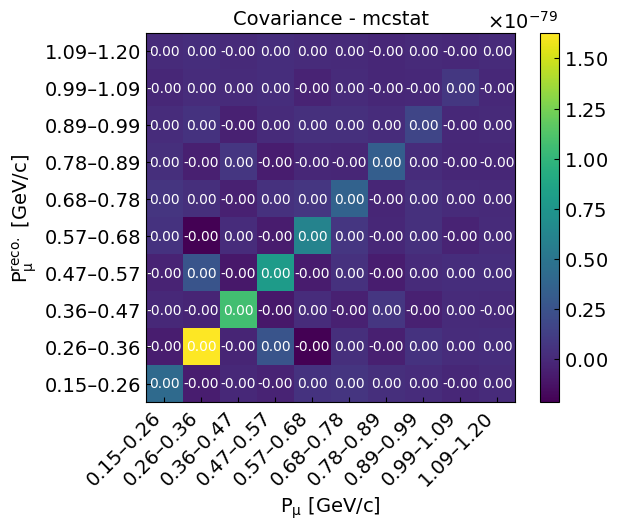

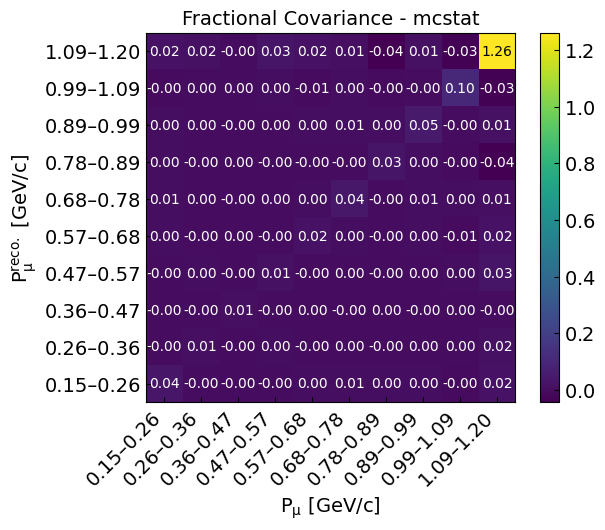

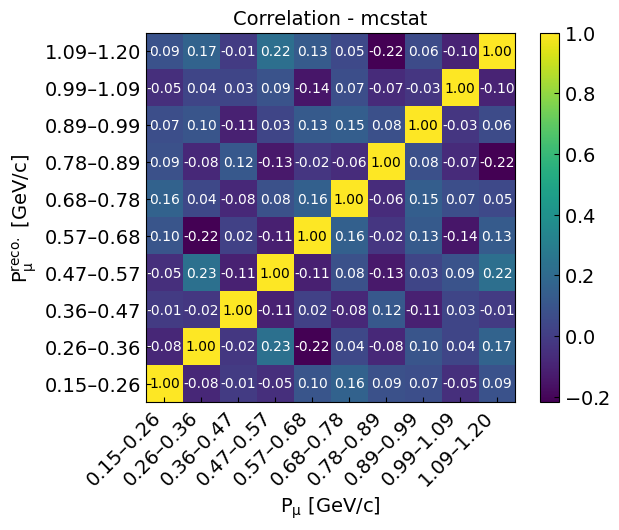

In [210]:
# sign of fractional covariance is different from the other two?
save_fig_name = "{}/{}-{}-mcstat_covariance".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_mcstat["Covariance"], "Covariance - mcstat",
             save_fig=save_fig, save_fig_name=save_fig_name)
save_fig_name = "{}/{}-{}-mcstat_covariance_frac".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_mcstat["Covariance_Frac"], "Fractional Covariance - mcstat",
             save_fig=save_fig, save_fig_name=save_fig_name)
save_fig_name = "{}/{}-{}-mcstat_correlation".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_mcstat["Correlation"], "Correlation - mcstat",
             save_fig=save_fig, save_fig_name=save_fig_name)

## Flux

generating covariance for xsec, using scale factor: 3.1078419006811257e-41


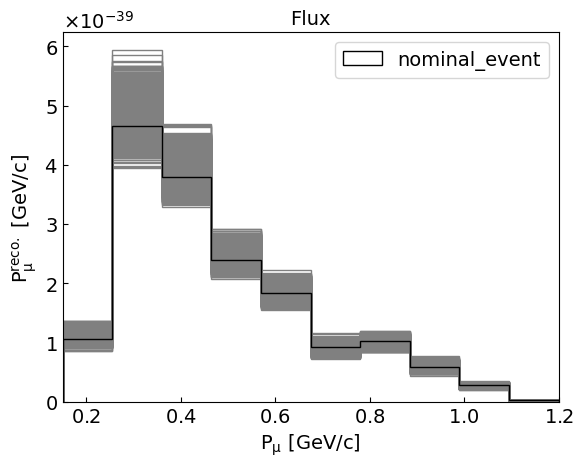

In [211]:
cov_type = "xsec"
syst_name = "Flux"
n_univ = 1000

labels = [var_config.var_labels[1], "Flux Integrated Event Rate"]

save_fig_name = "{}/{}-{}-flux_univ_events".format(save_fig_dir, var_config.var_save_name, syst_name)
ret_flux = get_covariance(cov_type, syst_name, n_univ, 
                          nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                          labels, save_fig=save_fig, save_fig_name=save_fig_name)

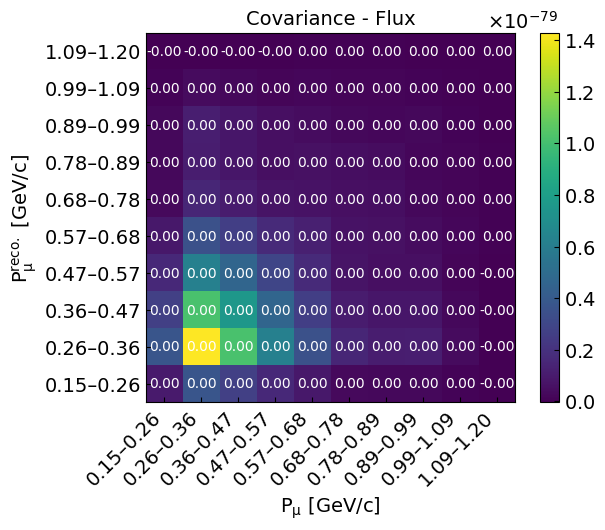

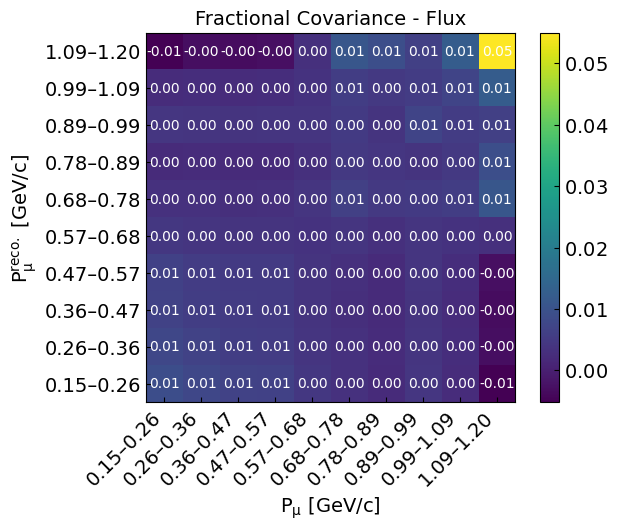

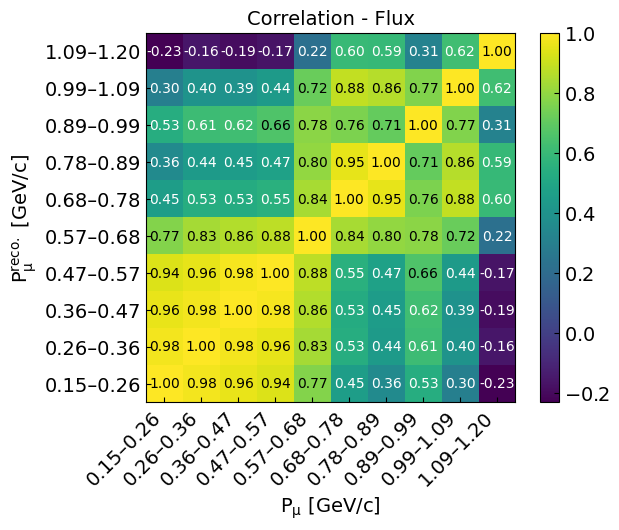

In [212]:
save_fig_name = "{}/{}-{}-flux_covariance".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_flux["Covariance"], "Covariance - Flux",
             save_fig=save_fig, save_fig_name=save_fig_name)
save_fig_name = "{}/{}-{}-flux_covariance_frac".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_flux["Covariance_Frac"], "Fractional Covariance - Flux",
             save_fig=save_fig, save_fig_name=save_fig_name)
save_fig_name = "{}/{}-{}-flux_correlation".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_flux["Correlation"], "Correlation - Flux",
             save_fig=save_fig, save_fig_name=save_fig_name)

## GENIE

### Multisims

generating covariance for xsec, using scale factor: 3.1078419006811257e-41


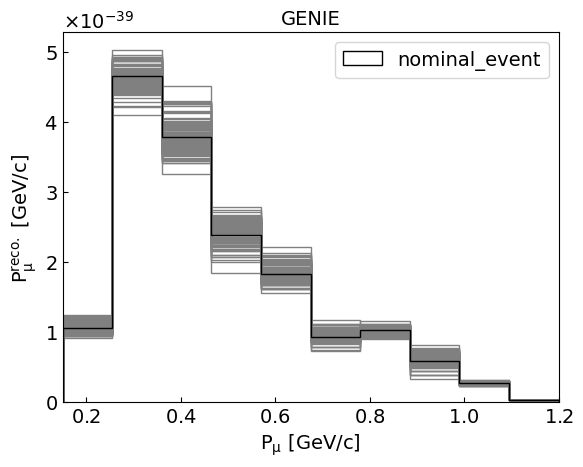

In [213]:
syst_type = "xsec"
syst_name = "GENIE"
n_univ = 100

labels = [var_config.var_labels[1], "Flux Integrated Event Rate"]

save_fig_name = "{}/{}-{}-genie_univ_events".format(save_fig_dir, var_config.var_save_name, syst_name)
ret_genie = get_covariance(cov_type, syst_name, n_univ, 
                          nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                          labels, save_fig=save_fig, save_fig_name=save_fig_name)

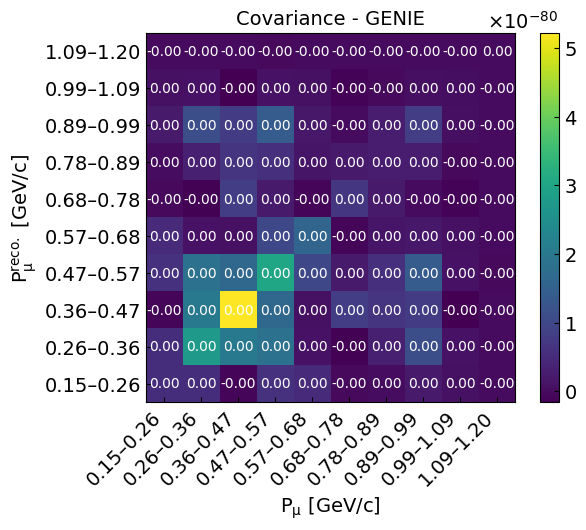

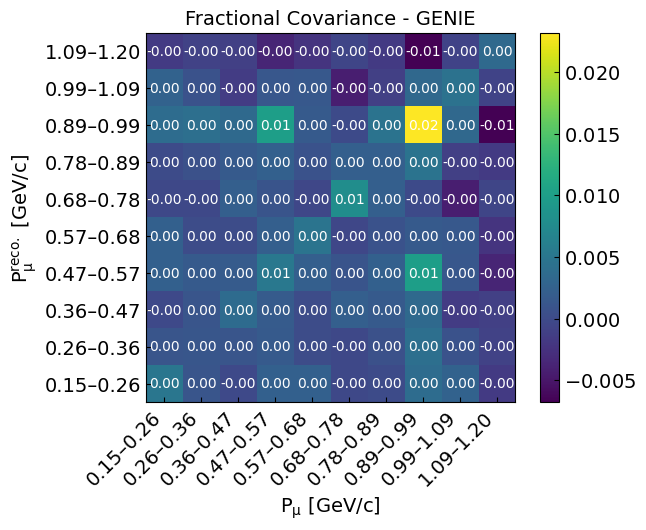

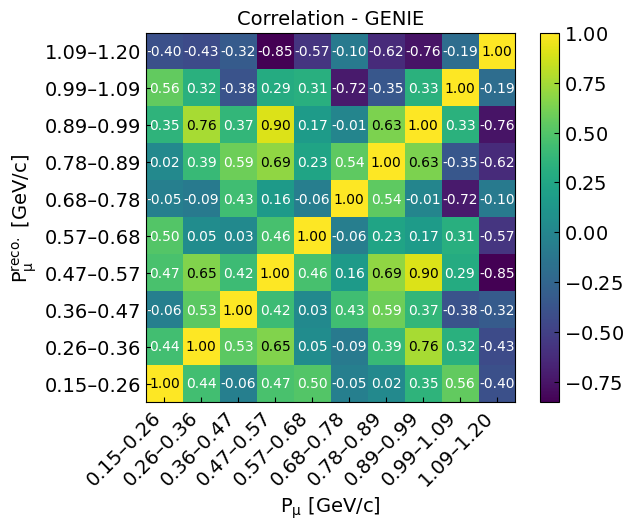

In [214]:
save_fig_name = "{}/{}-{}-genie_covariance".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_genie["Covariance"], "Covariance - GENIE",
             save_fig=save_fig, save_fig_name=save_fig_name)
save_fig_name = "{}/{}-{}-genie_covariance_frac".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_genie["Covariance_Frac"], "Fractional Covariance - GENIE",
             save_fig=save_fig, save_fig_name=save_fig_name)
save_fig_name = "{}/{}-{}-genie_correlation".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_genie["Correlation"], "Correlation - GENIE",
             save_fig=save_fig, save_fig_name=save_fig_name)

### Unisims

### Multisigma

- we treat this as a unisim using 1 sigma 

In [215]:
# inspect some knobs
knobs = [
    'GENIEReWeight_SBN_v1_multisigma_RPA_CCQE',
    'GENIEReWeight_SBN_v1_multisigma_CoulombCCQE',
    'GENIEReWeight_SBN_v1_multisigma_NormCCMEC',
    # 'GENIEReWeight_SBN_v1_multisigma_NormNCMEC',
    # 'GENIEReWeight_SBN_v1_multisigma_RDecBR1gamma',
]
knob = knobs[2]

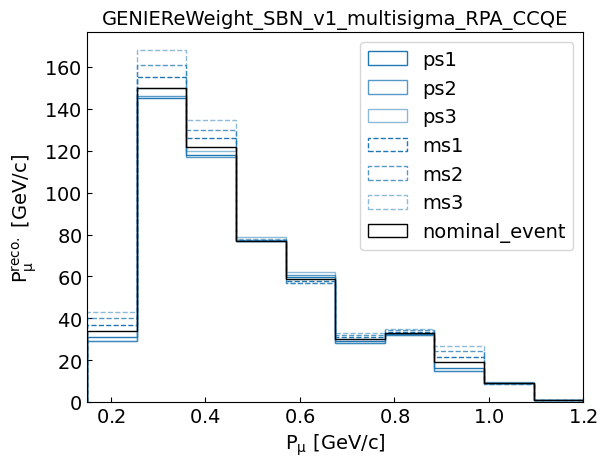

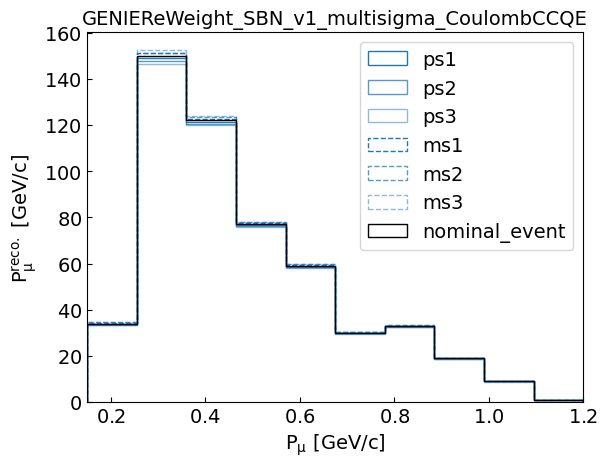

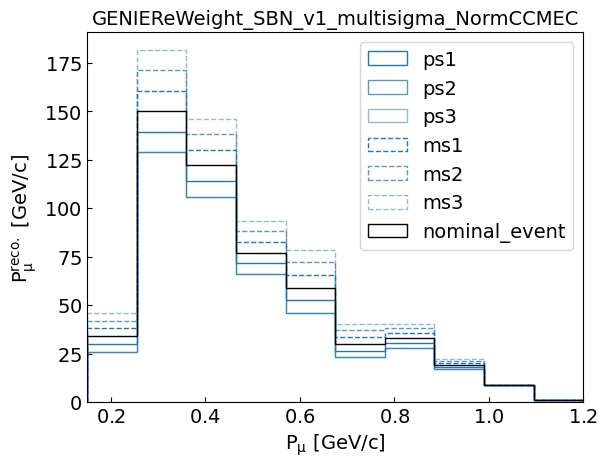

In [216]:
for knob in knobs:
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps1, histtype="step", 
            color="C0", label="ps1")
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps2, histtype="step", 
            color="C0", label="ps2", alpha=0.75)
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps3, histtype="step", 
            color="C0", label="ps3", alpha=0.5)
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms1, histtype="step", 
            color="C0", label="ms1", linestyle="--")
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms2, histtype="step", 
            color="C0", label="ms2", linestyle="--", alpha=0.75)
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms3, histtype="step", 
            color="C0", label="ms3", linestyle="--", alpha=0.5)

    # TODO: is there any purpose of using cv? seems redundant...
    # plt.hist(var_signal_sel_reco, bins=var_config.bins, histtype="step", color="black", label="nominal_event")
    plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].cv, histtype="step", color="black", label="nominal_event")

    plt.xlim(var_config.bins[0], var_config.bins[-1])
    plt.xlabel(var_config.var_labels[0])
    plt.ylabel(var_config.var_labels[1])
    plt.title(knob)
    plt.legend()
    plt.show()

generating covariance for event rate


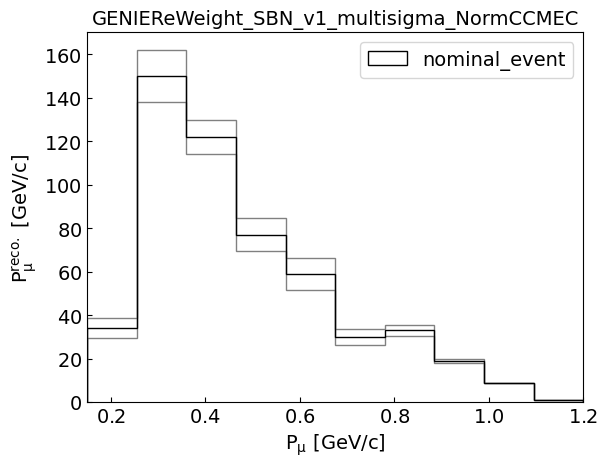

/tmp/ipykernel_1364573/1222275741.py:112: RuntimeWarning: invalid value encountered in scalar divide
  Correlation[i, j] = Covariance[i, j] / (np.sqrt(Covariance[i, i]) * np.sqrt(Covariance[j, j]))


In [226]:
cov_type = "event"
syst_name = knob
n_univ = 2

labels = [var_config.var_labels[1], "Flux Integrated Event Rate"]

save_fig_name = "{}/{}-{}-genie_univ_events".format(save_fig_dir, var_config.var_save_name, syst_name)
ret_genie = get_covariance(cov_type, syst_name, n_univ, 
                          nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                          labels, save_fig=save_fig, save_fig_name=save_fig_name)

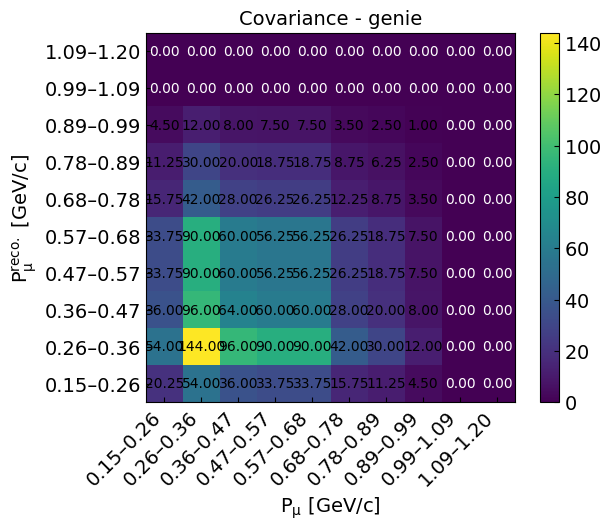

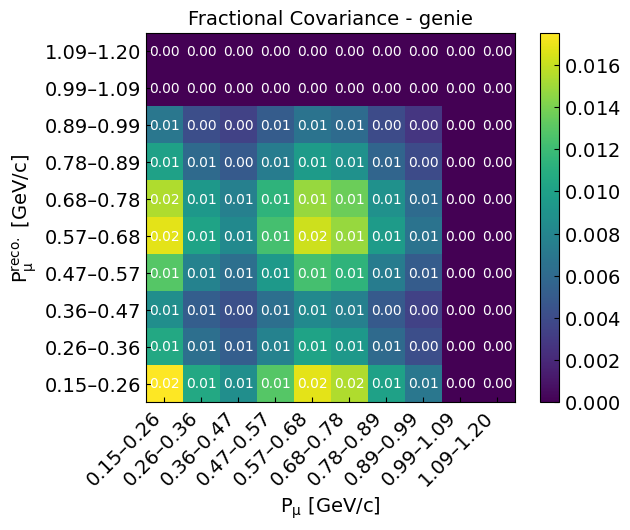

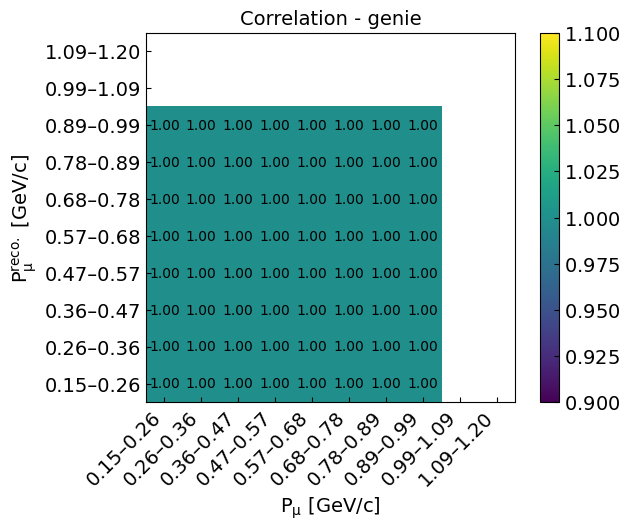

In [228]:
save_fig_name = "{}/{}-{}-genie_covariance".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_genie["Covariance"], "Covariance - genie",
             save_fig=save_fig, save_fig_name=save_fig_name)
save_fig_name = "{}/{}-{}-genie_covariance_frac".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_genie["Covariance_Frac"], "Fractional Covariance - genie",
             save_fig=save_fig, save_fig_name=save_fig_name)
save_fig_name = "{}/{}-{}-genie_correlation".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(ret_genie["Correlation"], "Correlation - genie",
             save_fig=save_fig, save_fig_name=save_fig_name)

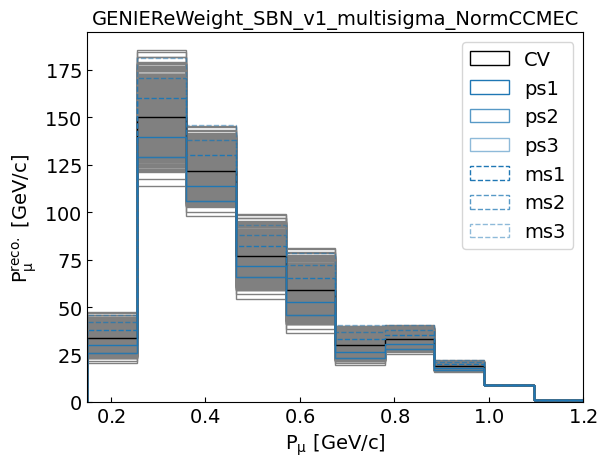

In [244]:
# ---- justification for the unisim treatment
# throw multivariate normal distribution to the bin center using 1 sigma,
# show that the 2 and 3 sigma are close to the 2 and 3 sigmas of the distribution, per bin

n_cv, _ = np.histogram(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].cv)
universes_from_1sigma = np.random.multivariate_normal(n_cv, ret_genie["Covariance"], size=1000)
for i in range(len(universes_from_1sigma)):
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=universes_from_1sigma[i], histtype="step", color="gray")

n_cv , _, _ = plt.hist(var_config.bin_centers, bins=var_config.bins, weights=n_cv, histtype="step", color="black", label="CV")
n_ps1, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps1, histtype="step", 
        color="C0", label="ps1")
n_ps2, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps2, histtype="step", 
        color="C0", label="ps2", alpha=0.75)
n_ps3, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ps3, histtype="step", 
        color="C0", label="ps3", alpha=0.5)
n_ms1, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms1, histtype="step", 
        color="C0", label="ms1", linestyle="--")
n_ms2, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms2, histtype="step", 
        color="C0", label="ms2", linestyle="--", alpha=0.75)
n_ms3, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=mc_evt_df[mc_evt_df.nuint_categ == 1][knob].ms3, histtype="step", 
        color="C0", label="ms3", linestyle="--", alpha=0.5)

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
plt.ylabel(var_config.var_labels[1])
plt.title(knob)
plt.legend()
plt.show()


array([113.99661222, 114.86214347, 119.87209563, 121.77303348,
       122.65073985, 121.93615503, 121.78018182])

In [254]:
[(1-0.997)/2., (1-0.95)/2., (1-0.68)/2., 0.5, 
                                      0.5+(0.68)/2., 0.5+(0.95)/2., 0.5+(0.997)/2.]

[0.0015000000000000013,
 0.025000000000000022,
 0.15999999999999998,
 0.5,
 0.8400000000000001,
 0.975,
 0.9984999999999999]

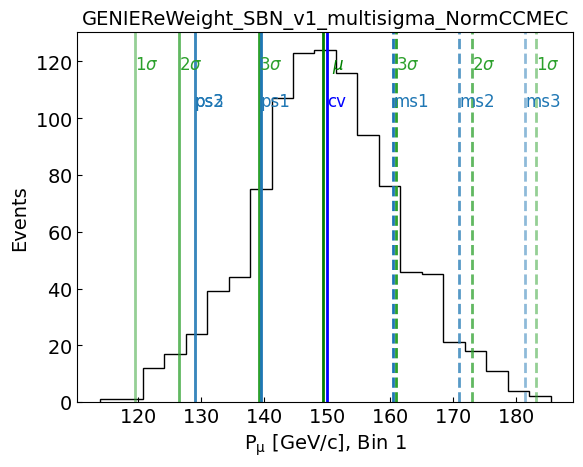

In [ ]:
bin_idx = 1

# distribuion of weights
this_wgts = universes_from_1sigma[:, bin_idx]
plt.hist(this_wgts, bins=21, histtype="step", color="black", label="weights from CAF ps1/ms1")

labels = ["3$\\sigma$", "2$\\sigma$", "1$\\sigma$"]

# sig levels from thrown universes
wgts_sig = np.percentile(this_wgts, np.array([(1-0.997)/2., (1-0.95)/2., (1-0.68)/2.,
                                      0.5+(0.68)/2., 0.5+(0.95)/2., 0.5+(0.997)/2.])*100)
wgts_cv = np.percentile(this_wgts, 50)
plt.axvline(wgts_cv, color="green", label="CV from weights")
plt.text(wgts_cv*1.01, plt.ylim()[1]*0.9, "$\\mu$", color="green", fontsize=12)
for sidx, s in enumerate(wgts_sig):
    if sidx <= 2:
        linestyle = "-"
        plt.axvline(s, color="C2", linestyle=linestyle, alpha=0.5+0.25*(sidx%3))
        plt.text(s, plt.ylim()[1]*0.9, labels[::-1][sidx%3], color="C2", fontsize=12)
    else:
        linestyle = "--"
        plt.axvline(s, color="C2", linestyle=linestyle, alpha=1-0.25*(sidx%3))
        plt.text(s, plt.ylim()[1]*0.9, labels[sidx%3], color="C2", fontsize=12)

# sig levels from cafs
plt.axvline(n_cv[bin_idx], color="blue")
plt.text(n_cv[bin_idx], plt.ylim()[1]*0.8, "cv", color="blue", fontsize=12)
plt.axvline(n_ps1[bin_idx], color="C0")
plt.text(n_ps1[bin_idx], plt.ylim()[1]*0.8, "ps1", color="C0", fontsize=12)
plt.axvline(n_ps2[bin_idx], color="C0", alpha=0.75)
plt.text(n_ps2[bin_idx], plt.ylim()[1]*0.8, "ps2", color="C0", fontsize=12)
plt.axvline(n_ps3[bin_idx], color="C0", alpha=0.5)
plt.text(n_ps3[bin_idx], plt.ylim()[1]*0.8, "ps3", color="C0", fontsize=12)
plt.axvline(n_ms1[bin_idx], color="C0", linestyle="--")
plt.text(n_ms1[bin_idx], plt.ylim()[1]*0.8, "ms1", color="C0", fontsize=12)
plt.axvline(n_ms2[bin_idx], color="C0", linestyle="--", alpha=0.75)
plt.text(n_ms2[bin_idx], plt.ylim()[1]*0.8, "ms2", color="C0", fontsize=12)
plt.axvline(n_ms3[bin_idx], color="C0", linestyle="--", alpha=0.5)
plt.text(n_ms3[bin_idx], plt.ylim()[1]*0.8, "ms3", color="C0", fontsize=12)
plt.xlabel(var_config.var_labels[0] + ", Bin " + str(bin_idx))
plt.ylabel("Events")

plt.title(knob)
plt.show()

## Total

In [115]:
# add fractional covariance of all systs, then multiply by the CV value to get the covariance
Total_Covariance_Frac = ret_flux["Covariance_Frac"] + ret_genie["Covariance_Frac"] + ret_mcstat["Covariance_Frac"]

Total_Covariance = np.zeros_like(Total_Covariance_Frac)
for i in range(len(var_config.bins)-1):
    for j in range(len(var_config.bins)-1):
        Total_Covariance[i, j] = Total_Covariance_Frac[i, j] * (nevts_signal_sel_reco[i] * nevts_signal_sel_reco[j]) * XSEC_UNIT**2

In [ ]:
ret_mcstat["Covariance"]

In [ ]:
save_fig_name = "{}/{}-{}-total_covariance_frac".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_heatmap(Total_Covariance_Frac, "Total Fractional Covariance",
             save_fig=save_fig, save_fig_name=save_fig_name)

In [ ]:
# fractional uncertainty
frac_uncert_flux = np.sqrt(np.diag(ret_flux["Covariance_Frac"]))
frac_uncert_genie = np.sqrt(np.diag(ret_genie["Covariance_Frac"]))
frac_uncert_mcstat = np.sqrt(np.diag(ret_mcstat["Covariance_Frac"]))
frac_uncert_total = np.sqrt(np.diag(Total_Covariance_Frac))

plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_flux*1e2, histtype="step", color="C0", label="Flux")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_genie*1e2, histtype="step", color="C1", label="GENIE")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_mcstat*1e2, histtype="step", color="C2", label="MCstat")
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_uncert_total*1e2, histtype="step", color="k", label="Total")

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
plt.ylabel("Uncertainty [%]")
plt.legend()

if save_fig:
    plt.savefig("{}/{}-uncertainty_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()


Singal distribution with error bars from diagonal components of covariance matrix

In [ ]:
# Compute bin centers for error bars
frac_uncert = np.sqrt(np.diag(Total_Covariance_Frac))
plt.errorbar(bin_centers, nevts_signal_sel_reco*XSEC_UNIT, yerr=frac_uncert*nevts_signal_sel_reco*XSEC_UNIT, fmt='o', color='black', label='Subtracted (syst. error)', capsize=3)
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
plt.ylabel("Events")
plt.legend()

if save_fig:
    plt.savefig("{}/{}-bkg_subtracted_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

# Unfolding

## Closure test 
- use MC signal as fake data

In [ ]:
# inspect topology breakdown
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_nuint_categ_mc,
                            bins=var_config.bins,
                            weights=weights_per_categ,
                            stacked=True,
                            color=colors,
                            label=mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')

totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
# plt.step(bin_edges[:-1], fake_data, where='post', label="Data")  # line
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data")
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-topology_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
# inspect GENIE mode breakdown
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_genie_mode_mc,
                            bins=var_config.bins,
                            weights=weights_per_genie_mode,
                            stacked=True,
                            color=genie_mode_colors,
                            label=genie_mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')

totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
# plt.step(bin_edges[:-1], fake_data, where='post', label="Data")  # line
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(genie_mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data")
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-genie_mode_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [122]:
# closure test -- just use MC stat uncertainty
C_type = 2
Norm_type = 0.5
Measured = nevts_signal_sel_reco * XSEC_UNIT # = fake_data - fake_background
Model = nevts_signal_truth * XSEC_UNIT
Covariance = ret_mcstat["Covariance"]
# Covariance = ret_flux["Covariance"]
unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

In [ ]:
unfold.keys()

In [ ]:
unfold['unfold']

In [ ]:
unfold['UnfoldCov']

In [126]:
def chi2(data, model, cov):
    return (data - model) @ np.linalg.inv(cov) @ (data - model)

In [ ]:
unfold['unfold']

In [ ]:
unfold['AddSmear'] @ nevts_signal_truth

In [ ]:
Unfold = unfold['unfold']
UnfoldCov = unfold['UnfoldCov']
Unfold_uncert = np.sqrt(np.diag(UnfoldCov))

step_handle, = plt.step(bin_edges, np.append(Unfold, Unfold[-1]), where='post', label='Unfolded', color='black')
bar_handle = plt.bar(
    bin_centers,
    2*Unfold_uncert,
    width=(bin_edges[1] - bin_edges[0]) * 1.,
    bottom=Unfold - Unfold_uncert,
    color='gray',
    alpha=0.5,
    linewidth=0,
    label='Unfolded Stat. error (box)'
)
reco_handle, = plt.plot(bin_centers, Measured, 'o', label='Reco. signal')
Model_smear = unfold['AddSmear'] @ Model
true_handle, = plt.plot(bin_centers, Model_smear, 'o', label='$A_c \\times$ True signal')

# chi2_val = chi2(Unfold, Model_smear, UnfoldCov)
# plt.text(0.95, 0.50, f"$ \\chi^2 = $ {chi2_val:.2f}", ha='right', va='center', 
#          transform=plt.gca().transAxes, fontsize=12)

# Custom order for legend
handles = [step_handle, bar_handle, reco_handle, true_handle]
labels = [
    'Unfolded',
    'Unfolded error',
    'Reco. signal',
    '$A_c \\times$True signal'
]

plt.legend(handles, labels)
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
# plt.ylim(0., 5000.)
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-unfolded_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)

## Fake Data Tests

- use alternate MC as fake data

### MEC scale

In [131]:
mec_scale = 2
weights_fake_data = np.ones(len(var_total_mc))
weights_fake_data[mc_evt_df.genie_mode == 10] = mec_scale

In [ ]:
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_nuint_categ_mc,
                            bins=var_config.bins,
                            weights=weights_per_categ,
                            stacked=True,
                            color=colors,
                            label=mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')
totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc * weights_fake_data)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

background_cv = mc_stack[-1] - mc_stack[0]
# plt.hist(bin_centers, weights=fake_data - background_cv, bins=var_config.bins, histtype="step", color="k", label="Background")

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data (MEC x{})".format(mec_scale))
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-topology_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
# inspect GENIE mode breakdown
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_genie_mode_mc,
                            bins=var_config.bins,
                            weights=weights_per_genie_mode,
                            stacked=True,
                            color=genie_mode_colors,
                            label=genie_mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')

totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc * weights_fake_data)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
# plt.step(bin_edges[:-1], fake_data, where='post', label="Data")  # line
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(genie_mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data (MEC x{})".format(mec_scale))
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-genie_mode_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [134]:
# fake data test -- MC stat + xsec cov
C_type = 2
Norm_type = 0.5
Measured = fake_data * XSEC_UNIT - background_cv * XSEC_UNIT
Model = nevts_signal_truth * XSEC_UNIT

# use MC stat and xsec cov
Covariance_Frac = ret_genie["Covariance_Frac"] + ret_mcstat["Covariance_Frac"]

Covariance = np.zeros_like(Covariance_Frac)
for i in range(len(var_config.bins)-1):
    for j in range(len(var_config.bins)-1):
        Covariance[i, j] = Covariance_Frac[i, j] * (nevts_signal_sel_reco[i] * nevts_signal_sel_reco[j]) * XSEC_UNIT**2

unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

In [ ]:
# true cross section for alt MC used asfake data
var_fakedata_signal_truth = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
var_fakedata_signal_truth = np.clip(var_fakedata_signal_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_fakedata_signal_truth = np.ones(len(var_fakedata_signal_truth))
nevts_fakedata_signal_truth, _, _ = plt.hist(var_fakedata_signal_truth, bins=var_config.bins, weights=weight_fakedata_signal_truth, histtype="step", label="True Signal")
weight_fakedata_signal_truth[mc_nu_df[mc_nu_df.nuint_categ == 1].genie_mode == 10] = mec_scale
nevts_fakedata_signal_truth, _, _ = plt.hist(var_fakedata_signal_truth, bins=var_config.bins, weights=weight_fakedata_signal_truth, histtype="step", label="MEC x2 True Signal")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
Unfold = unfold['unfold']
UnfoldCov = unfold['UnfoldCov']
Unfold_uncert = np.sqrt(np.diag(UnfoldCov))

step_handle, = plt.step(bin_edges, np.append(Unfold, Unfold[-1]), where='post', label='Unfolded', color='black')
bar_handle = plt.bar(
    bin_centers,
    2*Unfold_uncert,
    width=(bin_edges[1] - bin_edges[0]) * 1.,
    bottom=Unfold - Unfold_uncert,
    color='gray',
    alpha=0.5,
    linewidth=0,
    label='Unfolded Stat. error (box)'
)
reco_handle, = plt.plot(bin_centers, Measured, 'o', label='Reco. signal')
Model_smear = unfold['AddSmear'] @ Model
true_handle, = plt.plot(bin_centers, Model_smear, 'o', label='$A_c \\times$ True signal')
Fakedata_Model_smear = unfold['AddSmear'] @ nevts_fakedata_signal_truth*XSEC_UNIT
fake_true_handle, = plt.plot(bin_centers, Fakedata_Model_smear, 'o', label='Fake Data')

chi2_val = chi2(Unfold, Model_smear, UnfoldCov)
chi2_val_fakedata = chi2(Unfold, Fakedata_Model_smear, UnfoldCov)
# plt.text(0.95, 0.50, f"$ \\chi^2 = $ {chi2_val:.2f}", ha='right', va='center', 
#          transform=plt.gca().transAxes, fontsize=12)

# Custom order for legend
handles = [step_handle, bar_handle, reco_handle, true_handle, fake_true_handle]
labels = [
    'Unfolded',
    'Unfolded error',
    'Reco. signal',
    '$A_c \\times$Nominal Truth ($\\chi^2 = {:.2f}/{}$)'.format(chi2_val, len(var_config.bins)-1),
    '$A_c \\times$ MECx{} Truth ($\\chi^2 = {:.2f}/{}$)'.format(mec_scale, chi2_val_fakedata, len(var_config.bins)-1),
]

plt.legend(handles, labels, fontsize=12)
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
# plt.ylim(0., 5000.)
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-unfolded_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)

### QE scale

In [138]:
qe_scale = 1.2
weights_fake_data = np.ones(len(var_total_mc))
weights_fake_data[mc_evt_df.genie_mode == 0] = qe_scale

In [ ]:
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_nuint_categ_mc,
                            bins=var_config.bins,
                            weights=weights_per_categ,
                            stacked=True,
                            color=colors,
                            label=mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')
totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc * weights_fake_data)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

background_cv = mc_stack[-1] - mc_stack[0]
# plt.hist(bin_centers, weights=fake_data - background_cv, bins=var_config.bins, histtype="step", color="k", label="Background")

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data (QE x{})".format(qe_scale))
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-topology_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
# inspect GENIE mode breakdown
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_genie_mode_mc,
                            bins=var_config.bins,
                            weights=weights_per_genie_mode,
                            stacked=True,
                            color=genie_mode_colors,
                            label=genie_mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')

totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc * weights_fake_data)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
# plt.step(bin_edges[:-1], fake_data, where='post', label="Data")  # line
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(genie_mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data (QE x{})".format(qe_scale))
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-genie_mode_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [141]:
# fake data test -- MC stat + xsec cov
C_type = 2
Norm_type = 0.5
Measured = fake_data * XSEC_UNIT - background_cv * XSEC_UNIT
Model = nevts_signal_truth * XSEC_UNIT

# use MC stat and xsec cov
Covariance_Frac = ret_genie["Covariance_Frac"] + ret_mcstat["Covariance_Frac"]

Covariance = np.zeros_like(Covariance_Frac)
for i in range(len(var_config.bins)-1):
    for j in range(len(var_config.bins)-1):
        Covariance[i, j] = Covariance_Frac[i, j] * (nevts_signal_sel_reco[i] * nevts_signal_sel_reco[j]) * XSEC_UNIT**2

unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

In [ ]:
# true cross section for alt MC used asfake data
var_fakedata_signal_truth = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
var_fakedata_signal_truth = np.clip(var_fakedata_signal_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_fakedata_signal_truth = np.ones(len(var_fakedata_signal_truth))
nevts_fakedata_signal_truth, _, _ = plt.hist(var_fakedata_signal_truth, bins=var_config.bins, weights=weight_fakedata_signal_truth, histtype="step", label="True Signal")
weight_fakedata_signal_truth[mc_nu_df[mc_nu_df.nuint_categ == 1].genie_mode == 0] = qe_scale
nevts_fakedata_signal_truth, _, _ = plt.hist(var_fakedata_signal_truth, bins=var_config.bins, weights=weight_fakedata_signal_truth, histtype="step", label="QE x{} True Signal".format(qe_scale))
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
Unfold = unfold['unfold']
UnfoldCov = unfold['UnfoldCov']
Unfold_uncert = np.sqrt(np.diag(UnfoldCov))

step_handle, = plt.step(bin_edges, np.append(Unfold, Unfold[-1]), where='post', label='Unfolded', color='black')
bar_handle = plt.bar(
    bin_centers,
    2*Unfold_uncert,
    width=(bin_edges[1] - bin_edges[0]) * 1.,
    bottom=Unfold - Unfold_uncert,
    color='gray',
    alpha=0.5,
    linewidth=0,
    label='Unfolded Stat. error (box)'
)
reco_handle, = plt.plot(bin_centers, Measured, 'o', label='Reco. signal')
Model_smear = unfold['AddSmear'] @ Model
true_handle, = plt.plot(bin_centers, Model_smear, 'o', label='$A_c \\times$ True signal')
Fakedata_Model_smear = unfold['AddSmear'] @ nevts_fakedata_signal_truth*XSEC_UNIT
fake_true_handle, = plt.plot(bin_centers, Fakedata_Model_smear, 'o', label='Fake Data')

chi2_val = chi2(Unfold, Model_smear, UnfoldCov)
chi2_val_fakedata = chi2(Unfold, Fakedata_Model_smear, UnfoldCov)
# plt.text(0.95, 0.50, f"$ \\chi^2 = $ {chi2_val:.2f}", ha='right', va='center', 
#          transform=plt.gca().transAxes, fontsize=12)

# Custom order for legend
handles = [step_handle, bar_handle, reco_handle, true_handle, fake_true_handle]
labels = [
    'Unfolded',
    'Unfolded error',
    'Reco. signal',
    '$A_c \\times$Nominal Truth ($\\chi^2 = {:.2f}/{}$)'.format(chi2_val, len(var_config.bins)-1),
    '$A_c \\times$ QE x{} Truth ($\\chi^2 = {:.2f}/{}$)'.format(qe_scale, chi2_val_fakedata, len(var_config.bins)-1),
]

plt.legend(handles, labels, fontsize=12)
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
# plt.ylim(0., 5000.)
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-unfolded_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)

### Np background scale

In [145]:
Np_scale = 2
weights_fake_data = np.ones(len(var_total_mc))
weights_fake_data[mc_evt_df.nuint_categ == 2] = Np_scale

In [ ]:
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_nuint_categ_mc,
                            bins=var_config.bins,
                            weights=weights_per_categ,
                            stacked=True,
                            color=colors,
                            label=mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')
totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc * weights_fake_data)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

background_cv = mc_stack[-1] - mc_stack[0]
# plt.hist(bin_centers, weights=fake_data - background_cv, bins=var_config.bins, histtype="step", color="k", label="Background")

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data (Np x{})".format(Np_scale))
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-topology_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
# inspect GENIE mode breakdown
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_genie_mode_mc,
                            bins=var_config.bins,
                            weights=weights_per_genie_mode,
                            stacked=True,
                            color=genie_mode_colors,
                            label=genie_mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')

totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc * weights_fake_data)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
# plt.step(bin_edges[:-1], fake_data, where='post', label="Data")  # line
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(genie_mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data (Np x{})".format(Np_scale))
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-genie_mode_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [148]:
# fake data test -- MC stat + xsec cov
C_type = 2
Norm_type = 0.5
Measured = fake_data * XSEC_UNIT - background_cv * XSEC_UNIT
Model = nevts_signal_truth * XSEC_UNIT

# use MC stat and xsec cov
Covariance_Frac = ret_genie["Covariance_Frac"] + ret_mcstat["Covariance_Frac"]

Covariance = np.zeros_like(Covariance_Frac)
for i in range(len(var_config.bins)-1):
    for j in range(len(var_config.bins)-1):
        Covariance[i, j] = Covariance_Frac[i, j] * (nevts_signal_sel_reco[i] * nevts_signal_sel_reco[j]) * XSEC_UNIT**2

unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

In [ ]:
# true cross section for alt MC used asfake data
var_fakedata_signal_truth = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
var_fakedata_signal_truth = np.clip(var_fakedata_signal_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_fakedata_signal_truth = np.ones(len(var_fakedata_signal_truth))
nevts_fakedata_signal_truth, _, _ = plt.hist(var_fakedata_signal_truth, bins=var_config.bins, weights=weight_fakedata_signal_truth, histtype="step", label="True Signal")
weight_fakedata_signal_truth[mc_nu_df[mc_nu_df.nuint_categ == 1].nuint_categ == 2] = Np_scale
nevts_fakedata_signal_truth, _, _ = plt.hist(var_fakedata_signal_truth, bins=var_config.bins, weights=weight_fakedata_signal_truth, histtype="step", label="Np x{} True Signal".format(Np_scale))
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
Unfold = unfold['unfold']
UnfoldCov = unfold['UnfoldCov']
Unfold_uncert = np.sqrt(np.diag(UnfoldCov))

step_handle, = plt.step(bin_edges, np.append(Unfold, Unfold[-1]), where='post', label='Unfolded', color='black')
bar_handle = plt.bar(
    bin_centers,
    2*Unfold_uncert,
    width=(bin_edges[1] - bin_edges[0]) * 1.,
    bottom=Unfold - Unfold_uncert,
    color='gray',
    alpha=0.5,
    linewidth=0,
    label='Unfolded Stat. error (box)'
)
reco_handle, = plt.plot(bin_centers, Measured, 'o', label='Reco. signal')
Model_smear = unfold['AddSmear'] @ Model
true_handle, = plt.plot(bin_centers, Model_smear, 'o', label='$A_c \\times$ True signal')
Fakedata_Model_smear = unfold['AddSmear'] @ nevts_fakedata_signal_truth*XSEC_UNIT
fake_true_handle, = plt.plot(bin_centers, Fakedata_Model_smear, 'o', label='Fake Data')

chi2_val = chi2(Unfold, Model_smear, UnfoldCov)
chi2_val_fakedata = chi2(Unfold, Fakedata_Model_smear, UnfoldCov)
# plt.text(0.95, 0.50, f"$ \\chi^2 = $ {chi2_val:.2f}", ha='right', va='center', 
#          transform=plt.gca().transAxes, fontsize=12)

# Custom order for legend
handles = [step_handle, bar_handle, reco_handle, true_handle, fake_true_handle]
labels = [
    'Unfolded',
    'Unfolded error',
    'Reco. signal',
    '$A_c \\times$Nominal Truth ($\\chi^2 = {:.2f}/{}$)'.format(chi2_val, len(var_config.bins)-1),
    '$A_c \\times$ Np x{} Truth ($\\chi^2 = {:.2f}/{}$)'.format(Np_scale, chi2_val_fakedata, len(var_config.bins)-1),
]

plt.legend(handles, labels, fontsize=12)
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
# plt.ylim(0., 5000.)
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-unfolded_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)

### Signal scale

In [152]:
sig_scale = 1.2
weights_fake_data = np.ones(len(var_total_mc))
weights_fake_data[mc_evt_df.nuint_categ == 1] = sig_scale

In [ ]:
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_nuint_categ_mc,
                            bins=var_config.bins,
                            weights=weights_per_categ,
                            stacked=True,
                            color=colors,
                            label=mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')
totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc * weights_fake_data)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

background_cv = mc_stack[-1] - mc_stack[0]
# plt.hist(bin_centers, weights=fake_data - background_cv, bins=var_config.bins, histtype="step", color="k", label="Background")

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data (Np x{})".format(sig_scale))
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-topology_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
# inspect GENIE mode breakdown
plt.figure(figsize=(8, 6))
mc_stack, _, _ = plt.hist(var_per_genie_mode_mc,
                            bins=var_config.bins,
                            weights=weights_per_genie_mode,
                            stacked=True,
                            color=genie_mode_colors,
                            label=genie_mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')

totmc, bin_edges = np.histogram(var_total_mc, bins=var_config.bins, weights=weights_total_mc * weights_fake_data)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
# plt.step(bin_edges[:-1], fake_data, where='post', label="Data")  # line
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(genie_mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data (Np x{})".format(sig_scale))
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[1])
plt.ylim(0., 1.3 * fake_data.max())
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-genie_mode_breakdown.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [155]:
# fake data test -- MC stat + xsec cov
C_type = 2
Norm_type = 0.5
Measured = fake_data * XSEC_UNIT - background_cv * XSEC_UNIT
Model = nevts_signal_truth * XSEC_UNIT

# use MC stat and xsec cov
Covariance_Frac = ret_genie["Covariance_Frac"] + ret_mcstat["Covariance_Frac"]

Covariance = np.zeros_like(Covariance_Frac)
for i in range(len(var_config.bins)-1):
    for j in range(len(var_config.bins)-1):
        Covariance[i, j] = Covariance_Frac[i, j] * (nevts_signal_sel_reco[i] * nevts_signal_sel_reco[j]) * XSEC_UNIT**2

unfold = WienerSVD(Response, Model, Measured, Covariance, C_type, Norm_type)

In [ ]:
# true cross section for alt MC used asfake data
var_fakedata_signal_truth = mc_nu_df[mc_nu_df.nuint_categ == 1][var_config.var_nu_col]
var_fakedata_signal_truth = np.clip(var_fakedata_signal_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_fakedata_signal_truth = np.ones(len(var_fakedata_signal_truth))
nevts_fakedata_signal_truth, _, _ = plt.hist(var_fakedata_signal_truth, bins=var_config.bins, weights=weight_fakedata_signal_truth, histtype="step", label="True Signal")
weight_fakedata_signal_truth[mc_nu_df[mc_nu_df.nuint_categ == 1].nuint_categ == 1] = sig_scale
nevts_fakedata_signal_truth, _, _ = plt.hist(var_fakedata_signal_truth, bins=var_config.bins, weights=weight_fakedata_signal_truth, histtype="step", label="MEC x{} True Signal".format(mec_scale))
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
Unfold = unfold['unfold']
UnfoldCov = unfold['UnfoldCov']
Unfold_uncert = np.sqrt(np.diag(UnfoldCov))

step_handle, = plt.step(bin_edges, np.append(Unfold, Unfold[-1]), where='post', label='Unfolded', color='black')
bar_handle = plt.bar(
    bin_centers,
    2*Unfold_uncert,
    width=(bin_edges[1] - bin_edges[0]) * 1.,
    bottom=Unfold - Unfold_uncert,
    color='gray',
    alpha=0.5,
    linewidth=0,
    label='Unfolded Stat. error (box)'
)
reco_handle, = plt.plot(bin_centers, Measured, 'o', label='Reco. signal')
Model_smear = unfold['AddSmear'] @ Model
true_handle, = plt.plot(bin_centers, Model_smear, 'o', label='$A_c \\times$ True signal')
Fakedata_Model_smear = unfold['AddSmear'] @ nevts_fakedata_signal_truth*XSEC_UNIT
fake_true_handle, = plt.plot(bin_centers, Fakedata_Model_smear, 'o', label='Fake Data')

chi2_val = chi2(Unfold, Model_smear, UnfoldCov)
chi2_val_fakedata = chi2(Unfold, Fakedata_Model_smear, UnfoldCov)
# plt.text(0.95, 0.50, f"$ \\chi^2 = $ {chi2_val:.2f}", ha='right', va='center', 
#          transform=plt.gca().transAxes, fontsize=12)

# Custom order for legend
handles = [step_handle, bar_handle, reco_handle, true_handle, fake_true_handle]
labels = [
    'Unfolded',
    'Unfolded error',
    'Reco. signal',
    '$A_c \\times$Nominal Truth ($\\chi^2 = {:.2f}/{}$)'.format(chi2_val, len(var_config.bins)-1),
    '$A_c \\times$ Signal x{} Truth ($\\chi^2 = {:.2f}/{}$)'.format(sig_scale, chi2_val_fakedata, len(var_config.bins)-1),
]

plt.legend(handles, labels, fontsize=12)
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
# plt.ylim(0., 5000.)
plt.ylabel("Events")

if save_fig:
    plt.savefig("{}/{}-unfolded_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

In [ ]:
save_fig_name = "{}/{}-{}-add_smear".format(save_fig_dir, var_config.var_save_name, syst_name)
plot_labels = [var_config.var_labels[2], var_config.var_labels[1]]
plot_heatmap(unfold["AddSmear"], "$A_c$", plot_labels=plot_labels,
             save_fig=save_fig, save_fig_name=save_fig_name)